In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from termcolor import colored
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from tqdm import tqdm
import re

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
DataPath = 'Sarcasm_Headlines_Dataset_v2.json'

In [5]:
dataFile = open(DataPath)
data = [json.loads(line) for line in dataFile]


In [6]:
headline = []
isSarcastic = []
link = []

for item in data:
    headline.append(item["headline"])
    isSarcastic.append(item["is_sarcastic"])
    link.append(item["article_link"])

In [7]:
df = pd.DataFrame()
df["headline"] = headline
df["isSarcastic"] = isSarcastic
# df.head(n = 10).style.background_gradient(cmap = "autumn")

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
def preprocessInput():
  
  df["headline"] = df["headline"].apply(lambda x: " ".join(x.lower() for x in x.split()))
  df["headline"] = df["headline"].str.replace('[^\w\s]','')
  df["headline"] = df["headline"].str.replace('\d','')
  stopwordList = stopwords.words("english")
  df["headline"] = df["headline"].apply(lambda x: " ".join(x for x in x.split() if x not in stopwordList))
  df["headline"] = df["headline"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [10]:
preprocessInput()

In [11]:
x = df["headline"]
y = df["isSarcastic"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y,
                                                                    test_size = 0.20,
                                                                    shuffle = True,
                                                                    random_state = 11)

In [12]:
print(train_x.shape, test_x.shape)

(22802,) (5701,)


In [13]:
unique_words = set()
len_max = 0

for sent in tqdm(train_x):
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 22802/22802 [00:00<00:00, 901357.33it/s]

43
704


In [14]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(train_x))

train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(train_x, maxlen=len_max)
test_x = sequence.pad_sequences(test_x, maxlen=len_max)

print(train_x.shape, test_x.shape)

(22802, 704) (5701, 704)


In [15]:
earlyStopping = EarlyStopping(min_delta = 0.001, mode = "auto", verbose = 1,
                               monitor = "val_acc",
                               patience = 3)
callbacks = [earlyStopping]

In [17]:
model = Sequential()
model.add(Embedding(len(list(unique_words)), 100, input_length = len_max))
model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True))
model.add(Dense(25, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss = "
", optimizer = Adam(lr = 0.0045),
              metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 704, 100)          4300      
                                                                 
 lstm (LSTM)                 (None, 704, 64)           42240     
                                                                 
 dense (Dense)               (None, 704, 25)           1625      
                                                                 
 dropout (Dropout)           (None, 704, 25)           0         
                                                                 
 dense_1 (Dense)             (None, 704, 1)            26        
                                                                 
Total params: 48,191
Trainable params: 48,191
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_x, train_y, epochs = 3, validation_data = (test_x, test_y), 
                  batch_size = 512, verbose = 1, callbacks = callbacks)

Epoch 1/3
45/45 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5214

45/45 [==============================] - 164s 3s/step - loss: 0.6924 - accuracy: 0.5214 - val_loss: 0.6917 - val_accuracy: 0.5280
Epoch 2/3
45/45 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5237

45/45 [==============================] - 148s 3s/step - loss: 0.6922 - accuracy: 0.5237 - val_loss: 0.6916 - val_accuracy: 0.5280
Epoch 3/3
45/45 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5237

45/45 [==============================] - 145s 3s/step - loss: 0.6922 - accuracy: 0.5237 - val_loss: 0.6916 - val_accuracy: 0.5280


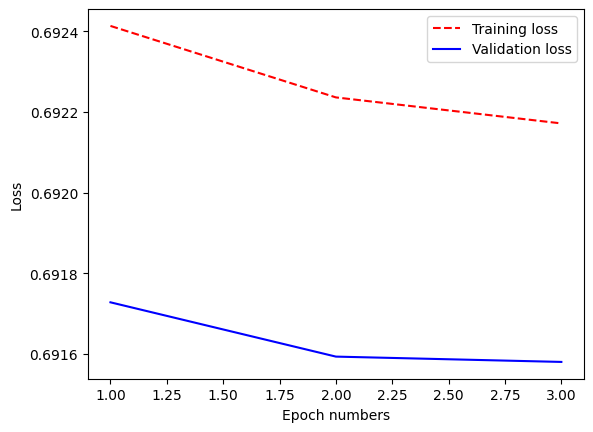

In [19]:
epoch_num = range(1, len(history.history["loss"]) + 1) 
plt.plot(epoch_num, history.history["loss"], "r--")
plt.plot(epoch_num, history.history["val_loss"], "b-")
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Epoch numbers")
plt.ylabel("Loss")
plt.show()

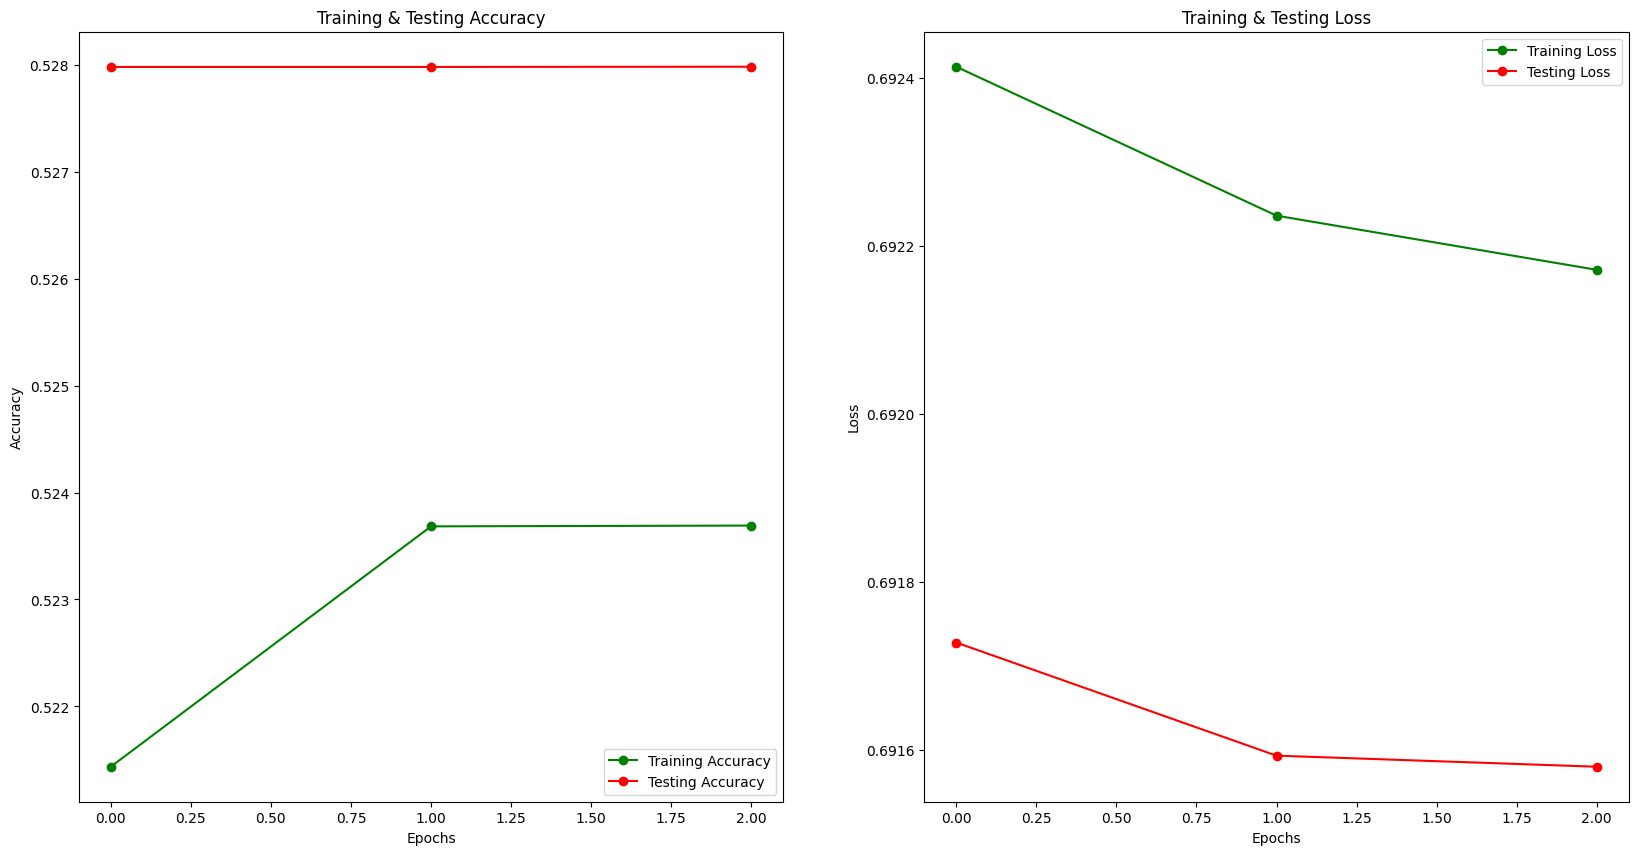

In [27]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)
ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()